In [1]:
import numpy as np
import scipy.optimize
import sympy
import matplotlib.pyplot as plt
import matplotlib as mpl

<font size = '5', style = 'line-height:5'>
solve &nbsp;
$\begin{align*}
x_1^2 + x_2^2 + x_3^2 & = 62 \\
x_1 - x_{2} + x_3 & = -8 \\
\frac{x_1  x_2 + x_2  x_3^2+2}{x_1 + x_3} & = -31
\end{align*}$
&nbsp; by using Newton-Jacobian

In [2]:
f = []
f.append(lambda x1,x2,x3: x1**2 + x2**2 + x3**2 - 62.0)
f.append(lambda x1,x2,x3: x1 - x2 + x3 + 8.0)
f.append(lambda x1,x2,x3: (x1 * x2 + x2 * x3**2 + 2)/(x1 + x3) + 31.0)
f

[<function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>]

In [3]:
f[0](2,3,-7)

0.0

In [4]:
f[1](2,3,-7)

0.0

In [5]:
f[2](2,3,-7)

0.0

In [6]:
x = [1,1,1]

In [7]:
f[2](*x)

33.0

In [8]:
f[2](1,1,1)

33.0

In [9]:
def jacobian(f,x):
    '''f is list of function\nx is list of points to calculate jacobian'''
    eps = 1e-8
    N = len(f)
    J = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[j] = x_plus[j] + eps
            x_minus[j] = x_minus[j] - eps
            J[i,j] = (f[i](*x_plus) - f[i](*x_minus))/eps * 0.5
    return J

In [10]:
jac_np = jacobian(f,x)
jac_np

array([[ 2.00000017,  2.00000017,  2.00000017],
       [ 1.00000008, -1.00000008,  1.00000008],
       [-0.49999969,  1.00000008,  0.        ]])

In [11]:
print(jacobian.__doc__)

f is list of function
x is list of points to calculate jacobian


# Double check jacobian function with sympy (manually)

In [12]:
x1, x2, x3 = sympy.symbols('x1, x2, x3')

In [13]:
fsym = []
fsym.append(x1**2 + x2**2 + x3**2 - 62.0)
fsym.append(x1 - x2 + x3 + 8.0)
fsym.append((x1 * x2 + x2 * x3**2 + 2)/(x1 + x3) + 31.0)
fsym

[x1**2 + x2**2 + x3**2 - 62.0,
 x1 - x2 + x3 + 8.0,
 31.0 + (x1*x2 + x2*x3**2 + 2)/(x1 + x3)]

In [14]:
x = [1,1,1]
xx = [x1,x2,x3]
for i in range(len(fsym)):
    for j in range(len(fsym)):
        print(sympy.diff(fsym[i],xx[j]).evalf(subs={x1:x[0], x2:x[1], x3:x[2]}), end = ' ')
    print('')

2.00000000000000 2.00000000000000 2.00000000000000 
1.00000000000000 -1.00000000000000 1.00000000000000 
-0.500000000000000 1.00000000000000 0.e-125 


# Double check with direct sympy function (pythonic way)

In [15]:
A_mat_sym = sympy.Matrix([fsym[0],fsym[1],fsym[2]])
y_mat_sym = sympy.Matrix([x1,x2,x3])
jac_sym = A_mat_sym.jacobian(y_mat_sym)
jac_sym

Matrix([
[                                              2*x1,                   2*x2,                                                    2*x3],
[                                                 1,                     -1,                                                       1],
[x2/(x1 + x3) - (x1*x2 + x2*x3**2 + 2)/(x1 + x3)**2, (x1 + x3**2)/(x1 + x3), 2*x2*x3/(x1 + x3) - (x1*x2 + x2*x3**2 + 2)/(x1 + x3)**2]])

In [16]:
jac_sym.subs({x1:1,x2:1,x3:1})

Matrix([
[   2,  2, 2],
[   1, -1, 1],
[-1/2,  1, 0]])

In [17]:
jac_sym.subs({x1:1,x2:1,x3:1}).evalf()

Matrix([
[ 2.0,  2.0, 2.0],
[ 1.0, -1.0, 1.0],
[-0.5,  1.0,   0]])

# Use Gaussian elimination with partial pivoting to solve for $\Delta \mathbf x$
# From &nbsp; $\mathbf{J}_ f \Delta \mathbf{x} = - \mathbf{f}$

In [18]:
def user_gaussian_solve_pp(a,b):
    A = np.hstack((a,b))
    N = A.shape[0]
    for k in range(N-1):
        maxidx = np.abs(A[k:,k]).argmax() + k #get index of the max arg
        # +k is needed, because, argmax restart at 0 for the new slice
        if k != maxidx:
            A[[k,maxidx]] = A[[maxidx, k]]
        for i in range(k+1, N):
            r = -A[i,k] / A[k,k]
            for j in range(k+1, N+1):
                A[i,j] = A[i,j] + r * A[k,j]

    A[N-1,N] = A[N-1,-1] / A[N-1, -2]
    for i in range(N-2, -1, -1): #2, 1, 0
        sum = 0
        for j in range(i+1, N): #i+1 to N-1
            sum = sum + A[i,j] * A[j,N]
        A[i,N] = (A[i,N] - sum)/A[i,i]
    return A[:,N][:,np.newaxis]

In [19]:
x_np = np.array(x)[:,np.newaxis]
x_np

array([[1],
       [1],
       [1]])

In [20]:
minus_f = np.array([- f[i](*x) for i in range(len(f))])[:,np.newaxis]
minus_f


array([[ 59.],
       [ -9.],
       [-33.]])

In [21]:
delta_x_np = user_gaussian_solve_pp(jac_np,minus_f)
delta_x_np

array([[ 104.50006561],
       [  19.24999841],
       [ -94.25006645]])

In [22]:
#recheck
jac_np.dot(delta_x_np) - minus_f

array([[  0.00000000e+00],
       [  0.00000000e+00],
       [ -7.10542736e-15]])

# Put everything together
<font size = '5', style = 'line-height:1.5'>
Specify $x_0$
<br> calculate jacobian
<br> solve for $\Delta x$
<br> move to the next point and redo the calculation
</font>

In [23]:
def newton_jacobian(f,x0, print_option = False, print_option2 = True):
    """f is list of function, x is list of initial guess value"""
    norm = 1
    maxitx = 100
    eps = 1e-8
    x = x0.copy()
    for k in range(maxitx):
        if print_option:
            print(x)
        jac_np = jacobian(f,x)
        minus_f = np.array([- f[i](*x) for i in range(len(f))])[:,np.newaxis]
        delta_x_np = user_gaussian_solve_pp(jac_np,minus_f)
        if np.linalg.norm(delta_x_np) < eps:
            break
        x = [x[i] + delta_x_np.reshape((1,-1))[0].tolist()[i] for i in range(len(f))]
        
    if print_option2:
        print('number of iteration = ',k+1)
    return x

In [24]:
ans = newton_jacobian(f,[1,1,1])
ans

number of iteration =  33


[2.0000000000000004, 2.9999999999999996, -7.000000000000001]

In [25]:
#to show how it converge
newton_jacobian(f,[1,1,1], print_option=True)

[1, 1, 1]
[105.50006560538831, 20.24999840724799, -93.25006645347705]
[54.11132368612264, 18.516236820916234, -43.595088097119344]
[27.373601340548323, 16.213946475131724, -19.1596548654167]
[13.063736669804877, 13.757689613406288, -7.306047056398594]
[5.103706863703587, 11.663234557579278, -1.4404715246727342]
[-0.7053895590350985, 10.385581415583175, 3.0909708611398727]
[1.5046399680376599, 8.933732295604948, -0.5709074761426867]
[-1.6185796578141662, 8.489105628982966, 2.107685128352942]
[0.012846827539433336, 8.254657450578309, 0.24181045731591477]
[-3.088289683423824, 7.8063475927257855, 2.894637236331696]
[-1.547012709939197, 7.880507759684931, 1.4275203393179778]
[0.28104645693942, 8.221169559147452, -0.05987689779196703]
[-1.5346426161610336, 7.949632893493651, 1.4842755541115267]
[-0.3440195274291271, 8.025631251606454, 0.3696507790355805]
[-1.9133632174401645, 7.733459029867682, 1.646822164639937]
[1.3824110435865702, 8.761560662667714, -0.620850380918855]
[-1.330977754707355

[2.0000000000000004, 2.9999999999999996, -7.000000000000001]

In [26]:
#check if the answer is correct
[f[i](*ans) for i in range(len(f))]

[1.4210854715202004e-14, 0.0, -7.105427357601002e-15]

In [27]:
np.linalg.norm(_)

1.5888218580782548e-14

In [28]:
#very close to the true answer (x1 = 2, x2 = 3, x3 = -7)

# Solve with scipy

In [29]:
def f_for_sp(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    f = []
    f.append(x1**2 + x2**2 + x3**2 - 62.0)
    f.append(x1 - x2 + x3 + 8.0)
    f.append((x1 * x2 + x2 * x3**2 + 2)/(x1 + x3) + 31.0)
    return f

In [30]:
scipy.optimize.fsolve(f_for_sp,[1,1,1], xtol = 1e-8)

array([ 0.17739906,  7.86584143, -0.31155763])

In [31]:
f_for_sp(_)

[-4.9737991503207013e-14, 0.0, 3.6294522942625917e-11]

In [32]:
scipy.optimize.fsolve(f_for_sp,[1,1,11], xtol = 1e-8)

array([ 2.,  3., -7.])

In [33]:
# different initial guess give different answer

In [34]:
try:
    scipy.optimize.broyden1(f_for_sp,[1,1,1], f_tol = 1e-8)
except Exception as e:
    print('exception = ', e)

In [35]:
try:
    scipy.optimize.broyden2(f_for_sp,[1,1,1], f_tol = 1e-8)
except Exception as e:
    print('exception = ', e)

exception =  [ -3.87514330e+10  -3.29995849e+10   2.49502102e+10]


/home/me/anaconda3/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1038: RuntimeWarning: invalid value encountered in true_divide
  d = v / df_norm**2


In [36]:
try:
    scipy.optimize.newton_krylov(f_for_sp,[1,1,1], f_tol = 1e-8)
except Exception as e:
    print('exception = ', e)

exception =  [ 0.30239854  0.87149907  1.6291792 ]


In [37]:
try:
    scipy.optimize.anderson(f_for_sp,[1,1,1], f_tol = 1e-8)
except Exception as e:
    print('exception = ', e)

exception =  [ 0.34888993  7.84307482 -0.58821917]


# Speed Comparison

In [38]:
%%timeit -n 5
scipy.optimize.fsolve(f_for_sp,[1,1,1], xtol = 1e-8)

5 loops, best of 3: 683 µs per loop


In [39]:
%%timeit -n 5
scipy.optimize.fsolve(f_for_sp,[1,1,11], xtol = 1e-8)

5 loops, best of 3: 330 µs per loop


In [40]:
%%timeit -n 5
newton_jacobian(f,[1,1,1],print_option2=False)

5 loops, best of 3: 2.8 ms per loop


In [41]:
scipy.optimize.fsolve(f_for_sp,[1,1,1], xtol = 1e-8)

array([ 0.17739906,  7.86584143, -0.31155763])

In [42]:
scipy.optimize.fsolve(f_for_sp,[1,1,11], xtol = 1e-8)

array([ 2.,  3., -7.])

In [43]:
newton_jacobian(f,[1,1,1],print_option2=False)

[2.0000000000000004, 2.9999999999999996, -7.000000000000001]

# Look at the error of the function at various points

In [44]:
def err_val(x1,x2,x3):
    f1 = (x1**2 + x2**2 + x3**2 - 62.0)
    f2 = (x1 - x2 + x3 + 8.0)
    f3 =((x1 * x2 + x2 * x3**2 + 2)/(x1 + x3) + 31.0)
    return np.sqrt(f1**2 + f2**2 + f3**2)

In [45]:
err_val(1,1,1)

68.198240446510056

In [46]:
err_val(np.ones([3,3]),np.ones([3,3]),np.ones([3,3]))

array([[ 68.19824045,  68.19824045,  68.19824045],
       [ 68.19824045,  68.19824045,  68.19824045],
       [ 68.19824045,  68.19824045,  68.19824045]])

In [47]:
x = np.arange(0,30,0.05)
y = np.arange(0,20,0.05)
X, Y = np.meshgrid(x, y)
Z = np.ones(X.shape)
Fxyz = err_val(X,Y,Z)

In [48]:
def user_surface_contour(X,Y,Z,x,y, filename = 'temp.png', title = 'f(x)',
                         savefile = True, figsize = (16,9), xlab = "\nx", ylab = "y\n"):
    font = {'size': 20}
    mpl.rc('font', **font)

    plt.figure(figsize=(16,9))

    contour = plt.contour(Z,10, linewidths=2,
                       cmap=plt.cm.afmhot,
                origin = 'lower', extent=(x.min(), x.max(), y.min(), y.max()))

    plt.clabel(contour, inline=True, fmt='%5d', fontsize=18, colors = 'black')
    pcol = plt.pcolor(X,Y,Z, cmap = 'jet')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar(pcol)
    plt.colorbar(contour)
    plt.title(title)
    if savefile:
        plt.savefig(filename)
    plt.show()

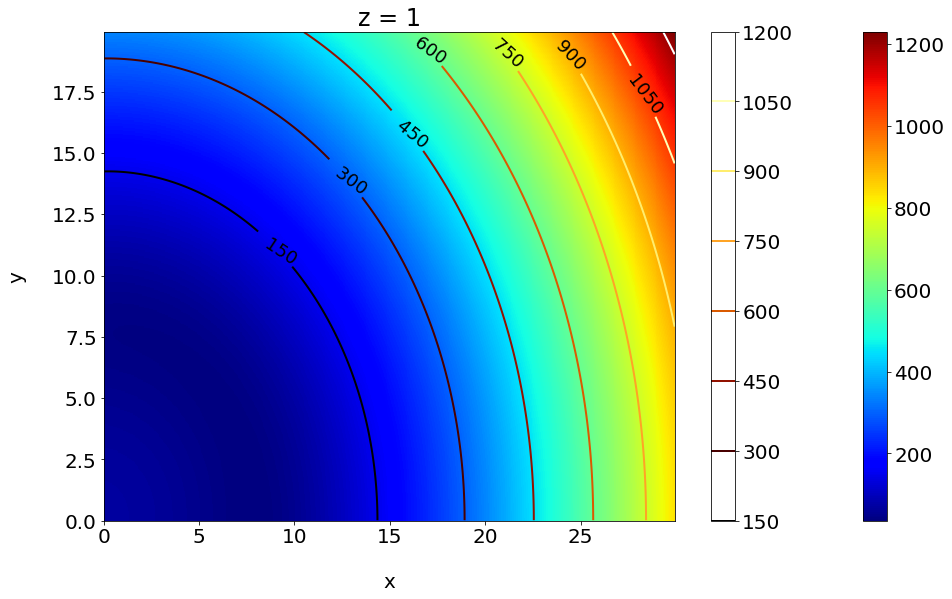

In [49]:
user_surface_contour(X,Y,Fxyz,x,y,title='z = 1')

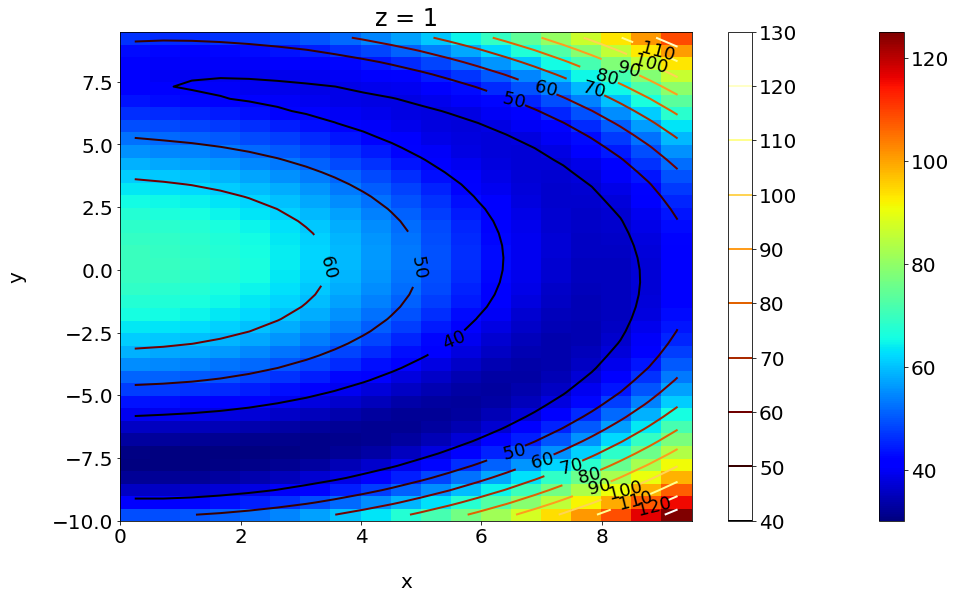

In [50]:
x = np.arange(0,10,0.5)
y = np.arange(-10,10,0.5)
X, Y = np.meshgrid(x, y)
Z = np.ones(X.shape)
Fxyz = err_val(X,Y,Z)
user_surface_contour(X,Y,Fxyz,x,y,title='z = 1')

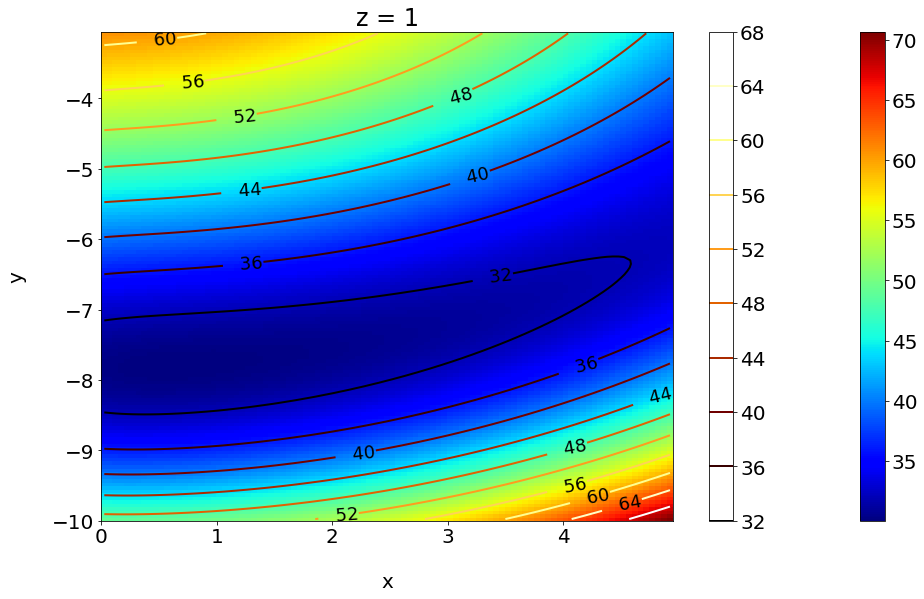

In [51]:
x = np.arange(0,5,0.05)
y = np.arange(-10,-3,0.05)
X, Y = np.meshgrid(x, y)
Z = np.ones(X.shape)
Fxyz = err_val(X,Y,Z)
user_surface_contour(X,Y,Fxyz,x,y,title='z = 1')

# At various $x_1$

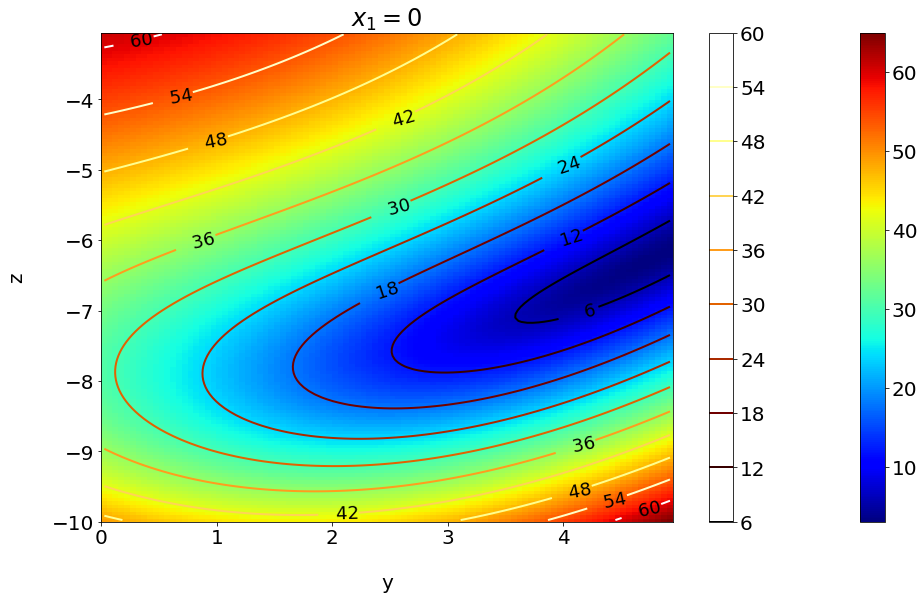

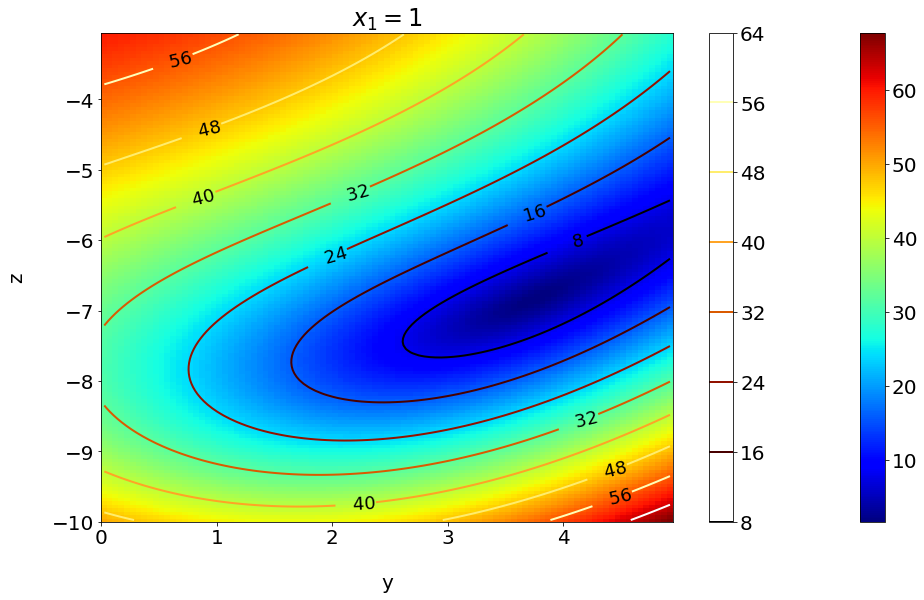

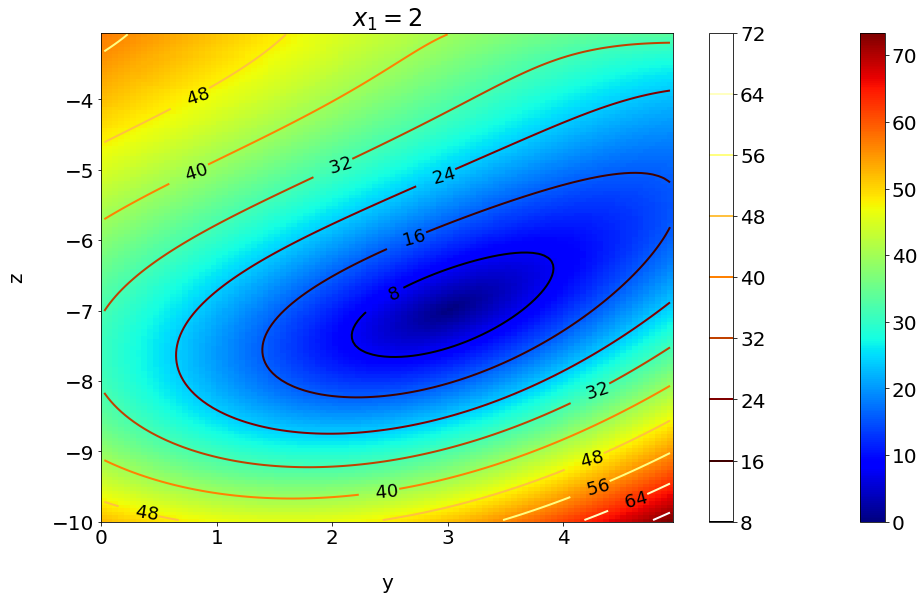

In [52]:
x = np.arange(0,5,0.05)
y = np.arange(-10,-3,0.05)
X, Y = np.meshgrid(x, y)
for i in range(3):
    Z = i * np.ones(X.shape)
    Fxyz = err_val(Z,X,Y)
    user_surface_contour(X,Y,Fxyz,x,y, xlab='\ny', 
                         ylab='z\n', title='$x_1= ' + str(i)+'$' , filename = str(i)+'_err.png')

# Checking Convergence

In [53]:
def newton_jacobian_check_conv(f,x0):
    """f is list of function, x is list of initial guess value,
    L is the true answer """
    norm = 1
    maxitx = 100
    eps = 1e-8
    x = x0.copy()
    x_his = []
    x_his.append(x)
    for k in range(maxitx):
        jac_np = jacobian(f,x)
        minus_f = np.array([- f[i](*x) for i in range(len(f))])[:,np.newaxis]
        delta_x_np = user_gaussian_solve_pp(jac_np,minus_f)

        x = [x[i] + delta_x_np.reshape((1,-1))[0].tolist()[i] for i in range(len(f))]
        x_his.append(x)
        if np.linalg.norm(delta_x_np) < eps:
            break
    print(x)
    return x_his

In [54]:
xHis = newton_jacobian_check_conv(f,[1,1,1])
xHis

[1.9999999999999996, 2.9999999999999996, -7.0]


[[1, 1, 1],
 [105.50006560538831, 20.24999840724799, -93.25006645347705],
 [54.11132368612264, 18.516236820916234, -43.595088097119344],
 [27.373601340548323, 16.213946475131724, -19.1596548654167],
 [13.063736669804877, 13.757689613406288, -7.306047056398594],
 [5.103706863703587, 11.663234557579278, -1.4404715246727342],
 [-0.7053895590350985, 10.385581415583175, 3.0909708611398727],
 [1.5046399680376599, 8.933732295604948, -0.5709074761426867],
 [-1.6185796578141662, 8.489105628982966, 2.107685128352942],
 [0.012846827539433336, 8.254657450578309, 0.24181045731591477],
 [-3.088289683423824, 7.8063475927257855, 2.894637236331696],
 [-1.547012709939197, 7.880507759684931, 1.4275203393179778],
 [0.28104645693942, 8.221169559147452, -0.05987689779196703],
 [-1.5346426161610336, 7.949632893493651, 1.4842755541115267],
 [-0.3440195274291271, 8.025631251606454, 0.3696507790355805],
 [-1.9133632174401645, 7.733459029867682, 1.646822164639937],
 [1.3824110435865702, 8.761560662667714, -0.620

In [55]:
len(xHis)

34

In [56]:
x_his = np.array(xHis)
x_his

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.05500066e+02,   2.02499984e+01,  -9.32500665e+01],
       [  5.41113237e+01,   1.85162368e+01,  -4.35950881e+01],
       [  2.73736013e+01,   1.62139465e+01,  -1.91596549e+01],
       [  1.30637367e+01,   1.37576896e+01,  -7.30604706e+00],
       [  5.10370686e+00,   1.16632346e+01,  -1.44047152e+00],
       [ -7.05389559e-01,   1.03855814e+01,   3.09097086e+00],
       [  1.50463997e+00,   8.93373230e+00,  -5.70907476e-01],
       [ -1.61857966e+00,   8.48910563e+00,   2.10768513e+00],
       [  1.28468275e-02,   8.25465745e+00,   2.41810457e-01],
       [ -3.08828968e+00,   7.80634759e+00,   2.89463724e+00],
       [ -1.54701271e+00,   7.88050776e+00,   1.42752034e+00],
       [  2.81046457e-01,   8.22116956e+00,  -5.98768978e-02],
       [ -1.53464262e+00,   7.94963289e+00,   1.48427555e+00],
       [ -3.44019527e-01,   8.02563125e+00,   3.69650779e-01],
       [ -1.91336322e+00,   7.73345903e+00,   1.6468221

In [57]:
map1 = map(np.linalg.norm, x_his)
x_norm = np.fromiter(map1, dtype = 'float32')
x_norm = x_norm.tolist()
x_norm

[1.7320507764816284,
 142.25294494628906,
 71.9125747680664,
 37.13890838623047,
 20.330114364624023,
 12.81225299835205,
 10.858728408813477,
 9.077524185180664,
 8.895339012145996,
 8.258208274841309,
 8.8800630569458,
 8.156805038452148,
 8.226189613342285,
 8.231334686279297,
 8.041501998901367,
 8.13507080078125,
 8.891651153564453,
 8.6574125289917,
 8.176021575927734,
 8.220869064331055,
 8.08804702758789,
 8.336273193359375,
 8.11016845703125,
 7.974195957183838,
 7.957045078277588,
 7.988382816314697,
 8.383286476135254,
 8.080288887023926,
 8.273421287536621,
 7.89511775970459,
 7.874218940734863,
 7.874007701873779,
 7.874007701873779,
 7.874007701873779]

In [58]:
np.linalg.norm(x_his[3] - x_his[2])

36.294582712662702

In [59]:
print('convergence of all x using norm')
import math
convergenceRate = []
for i in range(3, len(x_norm)):

    try:
        top = math.log(abs(x_norm[i] - x_norm[i-1]) / abs(x_norm[i-1] - x_norm[i-2]) )
    except Exception as e:
        print(e)

    try:
        bot = math.log(abs(x_norm[i-1] - x_norm[i-2]) / abs(x_norm[i-2] - x_norm[i-3]) )
    except Exception as e:
        print(e)

    convergenceRate.append(top/bot)

convergenceRate

convergence of all x using norm
math domain error
float division by zero
math domain error


[1.0180274796660957,
 1.0318994236091639,
 1.1068318866958107,
 1.6748846003378084,
 0.06852357677742095,
 24.690103243364327,
 -0.5490962945094151,
 -0.019384362639122427,
 -6.224563522576198,
 -15.517742811840362,
 1.1098602544527947,
 -1.3868653243740967,
 -0.19607144522685796,
 -2.9544467034148467,
 -0.5609596696215101,
 -0.6143785047063994,
 -3.2948527223482147,
 -0.4574606133183043,
 0.5759469516877568,
 -0.14926829581581547,
 5.44819988746556,
 4.071223815635157,
 -0.29113828064521113,
 4.203599183970548,
 -0.10455246036637283,
 1.699962266516677,
 -1.4928889960509835,
 -4.3074731870817375,
 1.5864819457987185,
 1.0,
 1.0]

In [60]:
sum(_)/len(_)

0.3924000426271738

In [61]:
print('convergence of all x')
import math
convergenceRate = []
for i in range(3, len(x_norm)):
    try:
        top = math.log(np.linalg.norm(x_his[i] - x_his[i-1]) / np.linalg.norm(x_his[i-1] - x_his[i-2]) )
    except Exception as e:
        print(e)
    try:
        bot = math.log(np.linalg.norm(x_his[i-1] - x_his[i-2]) / np.linalg.norm(x_his[i-2] - x_his[i-3]) )
    except Exception as e:
        print(e)
    convergenceRate.append(top/bot)
convergenceRate

convergence of all x


[0.9870403855985159,
 0.9750298870537146,
 0.9345830931060036,
 0.4879382173411863,
 1.6727574008712436,
 0.1735285730173008,
 5.809948099028897,
 -0.9842773012920887,
 -1.312600058343887,
 -0.1703771271704561,
 0.06624314889060816,
 -51.923375607075556,
 -0.5843281092764748,
 3.1281646427431067,
 -0.19597090917827836,
 3.5649474182440053,
 -0.14372466608742682,
 -3.4766419830599067,
 -1.599451079153515,
 -0.87301618118587,
 1.2629902786189333,
 0.2180655444301842,
 -1.7060113678171291,
 4.712089329837877,
 -0.6077127976464358,
 -0.7292568780726674,
 -4.405463790841907,
 1.5539950988656424,
 2.0874488098430692,
 1.9881263240120919,
 1.7883884413230615]

In [62]:
sum(_)/len(_)

-1.20325558591536

In [63]:
x1_his = np.array(x_his)[:,0]
x1_his

array([  1.00000000e+00,   1.05500066e+02,   5.41113237e+01,
         2.73736013e+01,   1.30637367e+01,   5.10370686e+00,
        -7.05389559e-01,   1.50463997e+00,  -1.61857966e+00,
         1.28468275e-02,  -3.08828968e+00,  -1.54701271e+00,
         2.81046457e-01,  -1.53464262e+00,  -3.44019527e-01,
        -1.91336322e+00,   1.38241104e+00,  -1.33097775e+00,
         1.12368030e-01,  -1.68193271e+00,  -2.93173431e-01,
        -2.38573872e+00,  -8.85582779e-01,  -1.38698044e-02,
         7.42502263e-01,   1.52770925e+00,   2.88242639e+00,
         2.74544825e+00,   2.49747436e+00,   2.03776835e+00,
         2.00033295e+00,   2.00000002e+00,   2.00000000e+00,
         2.00000000e+00])

In [64]:
convergenceRate = []
for i in range(3, x1_his.shape[0]):
    try:
        top = math.log(abs(x1_his[i] - x1_his[i-1]) / abs(x1_his[i-1] - x1_his[i-2]) )
    except Exception as e:
        print(e)
    try:
        bot = math.log(abs(x1_his[i-1] - x1_his[i-2]) / abs(x1_his[i-2] - x1_his[i-3]) )
    except Exception as e:
        print(e)
    convergenceRate.append(top/bot)
convergenceRate

[0.9205024683368113,
 0.956810673376366,
 0.9382366981945495,
 0.5370825279360333,
 3.06792228045496,
 -0.35787631158176453,
 -1.877674186614585,
 -0.9890735521979571,
 -1.088498009303331,
 -0.24407031512535815,
 -0.039789307714436825,
 62.150423396888,
 -0.6544748791136747,
 2.6865872626891387,
 -0.2620580599244278,
 3.2463762672570056,
 -0.34480295431355285,
 -1.1771324248762132,
 -1.6002051179551011,
 -0.8117997883301304,
 1.6310961400952608,
 0.2614407479305794,
 -0.26361439994775504,
 14.577466832538185,
 -4.201547675712043,
 -0.25899857704405066,
 1.040036235945333,
 -4.06304554686286,
 1.8829714271597349,
 2.02852390801268,
 1.781937513276364]

In [65]:
sum(_)/len(_)

2.5636372023701206

In [66]:
x1_his = np.array(x_his)[:,1]
convergenceRate = []
for i in range(3, x1_his.shape[0]):
    try:
        top = math.log(abs(x1_his[i] - x1_his[i-1]) / abs(x1_his[i-1] - x1_his[i-2]) )
    except Exception as e:
        print(e)
    try:
        bot = math.log(abs(x1_his[i-1] - x1_his[i-2]) / abs(x1_his[i-2] - x1_his[i-3]) )
    except Exception as e:
        print(e)
    convergenceRate.append(top/bot)
convergenceRate

math domain error


[-0.11781695773020036,
 0.22824977802609958,
 -2.4615316955835467,
 3.1018727291130483,
 -0.2585904003661948,
 -9.258506527473317,
 0.5408340002046786,
 -1.012890088280381,
 -2.7755608002696457,
 -0.847384573607759,
 -0.148749600868057,
 5.614747159792504,
 -1.0575208791733943,
 0.9342761526768532,
 -0.7906763309450863,
 0.6143336254520199,
 -0.5191006995652659,
 -1.3828960371650694,
 -1.5839541966907913,
 -0.27067943674882455,
 11.126141147077757,
 -0.4674506165438778,
 1.036228672929949,
 1.2612354980921858,
 0.2441342883728437,
 1.1165014188411109,
 -5.130876176721195,
 1.1148482604022933,
 2.4431953153741115,
 1.9583375605959457,
 1.0]

In [67]:
sum(_)/len(_)

0.13712098674899342

In [68]:
x1_his = np.array(x_his)[:,2]
convergenceRate = []
for i in range(3, x1_his.shape[0]):
    try:
        top = math.log(abs(x1_his[i] - x1_his[i-1]) / abs(x1_his[i-1] - x1_his[i-2]) )
    except Exception as e:
        print(e)
    try:
        bot = math.log(abs(x1_his[i-1] - x1_his[i-2]) / abs(x1_his[i-2] - x1_his[i-3]) )
    except Exception as e:
        print(e)
    convergenceRate.append(top/bot)
convergenceRate

[1.1064386530362298,
 1.0202204327382223,
 0.9725321290684132,
 0.366806956527936,
 0.8256367392120872,
 1.4675618858683115,
 1.1563135565581233,
 -0.9732667152982023,
 -1.6832440871059438,
 -0.023177401397369624,
 2.727695234228034,
 -8.70440260136694,
 -0.4176311692056711,
 4.217339395414956,
 0.04961035378295328,
 -12.17081085570617,
 0.2535059341949272,
 2.5649307132062726,
 -1.5915927597357324,
 -1.0213671958000219,
 0.7503103334274629,
 0.21947772834218932,
 -3.5363552401701877,
 3.7128478733266395,
 -0.8335708418833605,
 -0.47929395610558306,
 -7.79471722356865,
 1.2773082305730346,
 3.017940124981897,
 0.6394785984429977,
 2.294145257521078]

In [69]:
sum(_)/len(_)

-0.3415912876416797

In [70]:
np.set_printoptions(suppress = True)
x_his

array([[   1.        ,    1.        ,    1.        ],
       [ 105.50006561,   20.24999841,  -93.25006645],
       [  54.11132369,   18.51623682,  -43.5950881 ],
       [  27.37360134,   16.21394648,  -19.15965487],
       [  13.06373667,   13.75768961,   -7.30604706],
       [   5.10370686,   11.66323456,   -1.44047152],
       [  -0.70538956,   10.38558142,    3.09097086],
       [   1.50463997,    8.9337323 ,   -0.57090748],
       [  -1.61857966,    8.48910563,    2.10768513],
       [   0.01284683,    8.25465745,    0.24181046],
       [  -3.08828968,    7.80634759,    2.89463724],
       [  -1.54701271,    7.88050776,    1.42752034],
       [   0.28104646,    8.22116956,   -0.0598769 ],
       [  -1.53464262,    7.94963289,    1.48427555],
       [  -0.34401953,    8.02563125,    0.36965078],
       [  -1.91336322,    7.73345903,    1.64682216],
       [   1.38241104,    8.76156066,   -0.62085038],
       [  -1.33097775,    8.38136008,    1.7123377 ],
       [   0.11236803,    8.

With more non-linear equations, Newton-Jacobian can go beyond the solution point and come back later (x1 solution is 2 but NJ move from 1 to 105, then decreases to -0.7)